In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm.notebook import tqdm


class SimCLRDualTransformDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        
        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            img1 = self.transform(image)
            img2 = self.transform(image)
        return img1, img2

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
data_dir = "../image-to-image-generation/makoto-shinkai-sketch-to-anime-dataset/shinkai_set"
dataset = SimCLRDualTransformDataset(root_dir=data_dir, transform=train_transforms)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimCLRv2(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLRv2, self).__init__()
        self.backbone = base_model
        num_ftrs = self.backbone.fc.in_features  # Access in_features before replacing
        self.backbone.fc = nn.Identity()  # Remove the original fully connected layer
        self.projection_head = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, out_dim)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        projections = self.projection_head(features)
        return projections

# Initialize a larger ResNet model, for example, ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=False)
model = SimCLRv2(base_model=resnet50, out_dim=128).to(device)

/home/riset/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/riset/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature, device):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.similarity_f = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        # Exclude self-similarities (diagonal elements)
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        positives = torch.cat((sim_i_j, sim_j_i), dim=0)
        
        # Exclude diagonal elements
        mask = torch.eye(N, dtype=torch.bool, device=self.device)
        negatives = sim[~mask].view(N, -1)
        
        labels = torch.zeros(N, dtype=torch.long, device=self.device)
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        
        # Compute cross-entropy loss
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

criterion = NTXentLoss(batch_size=128, temperature=0.5, device=device)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

In [4]:
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    # Use tqdm to create a progress bar for the training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for (x_i, x_j) in progress_bar:
        x_i, x_j = x_i.to(device), x_j.to(device)
        z_i, z_j = model(x_i), model(x_j)
        loss = criterion(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=total_loss / len(progress_bar))
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}")

print("Training completed.")

Epoch 1/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [1/100], Loss: 4.7961205381207765


Epoch 2/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [2/100], Loss: 4.5848639043031545


Epoch 3/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [3/100], Loss: 4.491459449835583


Epoch 4/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [4/100], Loss: 4.465847146194593


Epoch 5/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [5/100], Loss: 4.4414825956378365


Epoch 6/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [6/100], Loss: 4.419696735069815


Epoch 7/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [7/100], Loss: 4.407511649933537


Epoch 8/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [8/100], Loss: 4.391760054942781


Epoch 9/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [9/100], Loss: 4.3743700780699735


Epoch 10/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [10/100], Loss: 4.365155837177175


Epoch 11/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [11/100], Loss: 4.3450177380468995


Epoch 12/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [12/100], Loss: 4.348459560259253


Epoch 13/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [13/100], Loss: 4.332423402144846


Epoch 14/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [14/100], Loss: 4.323900177415493


Epoch 15/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [15/100], Loss: 4.314159826894777


Epoch 16/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [16/100], Loss: 4.301474750569437


Epoch 17/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [17/100], Loss: 4.288072702104011


Epoch 18/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [18/100], Loss: 4.273064686133798


Epoch 19/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [19/100], Loss: 4.264677864260378


Epoch 20/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [20/100], Loss: 4.255859762166454


Epoch 21/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [21/100], Loss: 4.245787374741208


Epoch 22/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [22/100], Loss: 4.242486007445682


Epoch 23/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [23/100], Loss: 4.225167571970847


Epoch 24/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [24/100], Loss: 4.227240878923804


Epoch 25/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [25/100], Loss: 4.214790744064128


Epoch 26/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [26/100], Loss: 4.2155604837215055


Epoch 27/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [27/100], Loss: 4.209458207662126


Epoch 28/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [28/100], Loss: 4.2047960220185


Epoch 29/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [29/100], Loss: 4.202152545473217


Epoch 30/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [30/100], Loss: 4.198915592337077


Epoch 31/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [31/100], Loss: 4.189719929104358


Epoch 32/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [32/100], Loss: 4.186199373903528


Epoch 33/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [33/100], Loss: 4.190201735074541


Epoch 34/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [34/100], Loss: 4.186885674442865


Epoch 35/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [35/100], Loss: 4.1847514220043625


Epoch 36/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [36/100], Loss: 4.18024951588791


Epoch 37/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [37/100], Loss: 4.174563152600179


Epoch 38/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [38/100], Loss: 4.171216184059076


Epoch 39/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [39/100], Loss: 4.1699446893371315


Epoch 40/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [40/100], Loss: 4.169342197148146


Epoch 41/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [41/100], Loss: 4.164575850014138


Epoch 42/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [42/100], Loss: 4.164626717567444


Epoch 43/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [43/100], Loss: 4.158396113235338


Epoch 44/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [44/100], Loss: 4.152486239914346


Epoch 45/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [45/100], Loss: 4.153601402730013


Epoch 46/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [46/100], Loss: 4.148077952123321


Epoch 47/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [47/100], Loss: 4.147171919324757


Epoch 48/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [48/100], Loss: 4.14933592872282


Epoch 49/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [49/100], Loss: 4.144285271653032


Epoch 50/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [50/100], Loss: 4.143731114083686


Epoch 51/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [51/100], Loss: 4.142270064986913


Epoch 52/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [52/100], Loss: 4.141958264123022


Epoch 53/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [53/100], Loss: 4.138505095929171


Epoch 54/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [54/100], Loss: 4.135797120828544


Epoch 55/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [55/100], Loss: 4.132362055567514


Epoch 56/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [56/100], Loss: 4.129190362660231


Epoch 57/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [57/100], Loss: 4.125085123872335


Epoch 58/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [58/100], Loss: 4.12525770938502


Epoch 59/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [59/100], Loss: 4.130932567393885


Epoch 60/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [60/100], Loss: 4.123395639183247


Epoch 61/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [61/100], Loss: 4.118956162866238


Epoch 62/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [62/100], Loss: 4.118304842341263


Epoch 63/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [63/100], Loss: 4.117117783664602


Epoch 64/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [64/100], Loss: 4.118491181230123


Epoch 65/100:   0%|          | 0/226 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch [90/100], Loss: 4.0720440318099165


Epoch 91/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [91/100], Loss: 4.073221338533722


Epoch 92/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [92/100], Loss: 4.070569195578583


Epoch 93/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [93/100], Loss: 4.063534161685842


Epoch 94/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [94/100], Loss: 4.067432482685663


Epoch 95/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [95/100], Loss: 4.06680641976078


Epoch 96/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [96/100], Loss: 4.064075880346045


Epoch 97/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [97/100], Loss: 4.061799335268747


Epoch 98/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [98/100], Loss: 4.060728980376657


Epoch 99/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [99/100], Loss: 4.061788607487636


Epoch 100/100:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch [100/100], Loss: 4.062327656070743
Training completed.


In [5]:
# save_path = "./simclrv2.pth"
# torch.save(model.state_dict(), save_path)

In [42]:
model.load_state_dict(
    torch.load("./simclrv2.pth")
)

<All keys matched successfully>

In [53]:
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update validation dataset with validation transforms
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)


In [44]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return torch.sigmoid(self.fc(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 128 # Adjust this based on your image size and number of channels
num_classes = len(dataset.classes)
clf = SimpleClassifier(input_dim, num_classes).to(device)

In [54]:
# Feature Extraction
def extract_features_and_labels(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for (images, targets) in dataloader:
            images = images.to(device)
            feat = model.backbone(images)  # Extract features using the backbone
            features.append(feat.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

# Extract features and labels
train_features, train_labels = extract_features_and_labels(model, train_loader, device)
val_features, val_labels = extract_features_and_labels(model, val_loader, device)

In [59]:
# Define the linear classifier using torch.nn.Linear and train it using L-BFGS
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def train_linear_classifier(classifier, features, labels, device, epochs=100):
    classifier = classifier.to(device)
    features = features.to(device)
    labels = labels.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.LBFGS(classifier.parameters())

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {closure().item()}")

# Define and train the linear classifier
input_dim = train_features.size(1)
num_classes = 2  # Automatically determine number of classes
classifier = LinearClassifier(input_dim, num_classes)
train_linear_classifier(classifier, train_features, train_labels, device)

Epoch [1/100], Loss: 0.006063874810934067
Epoch [2/100], Loss: 0.0007958076894283295
Epoch [3/100], Loss: 3.514560660278221e-07
Epoch [4/100], Loss: 5.085250975866984e-08
Epoch [5/100], Loss: 5.085250975866984e-08
Epoch [6/100], Loss: 5.085250975866984e-08
Epoch [7/100], Loss: 5.085250975866984e-08
Epoch [8/100], Loss: 5.085250975866984e-08
Epoch [9/100], Loss: 5.085250975866984e-08
Epoch [10/100], Loss: 5.085250975866984e-08
Epoch [11/100], Loss: 5.085250975866984e-08
Epoch [12/100], Loss: 5.085250975866984e-08
Epoch [13/100], Loss: 5.085250975866984e-08
Epoch [14/100], Loss: 5.085250975866984e-08
Epoch [15/100], Loss: 5.085250975866984e-08
Epoch [16/100], Loss: 5.085250975866984e-08
Epoch [17/100], Loss: 5.085250975866984e-08
Epoch [18/100], Loss: 5.085250975866984e-08
Epoch [19/100], Loss: 5.085250975866984e-08
Epoch [20/100], Loss: 5.085250975866984e-08
Epoch [21/100], Loss: 5.085250975866984e-08
Epoch [22/100], Loss: 5.085250975866984e-08
Epoch [23/100], Loss: 5.085250975866984e-0

In [64]:
def evaluate_model(classifier, features, labels, device):
    classifier.eval()
    features = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = classifier(features)
        _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy(), labels.cpu().numpy()

In [66]:
y_pred, y_true = evaluate_model(classifier, val_features, val_labels, device)

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

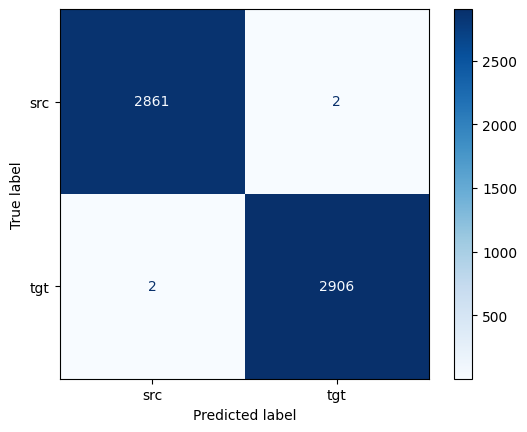

In [70]:
plot_confusion_matrix(y_true, y_pred, classes=val_dataset.dataset.classes)

In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9993    0.9993    0.9993      2863
           1     0.9993    0.9993    0.9993      2908

    accuracy                         0.9993      5771
   macro avg     0.9993    0.9993    0.9993      5771
weighted avg     0.9993    0.9993    0.9993      5771



In [74]:
len(val_dataset)

5771